<a href="https://colab.research.google.com/github/Sathwik2410/L00187609_Dissertation_September_2025/blob/main/XLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch

In [ ]:
df=pd.read_csv("/content/cleaned_data (1).csv",sep=',')
df=df.dropna()
print(df['Label'].value_counts())

Label
not_cyberbullying    2002
cyberbullying        1911
Name: count, dtype: int64


In [ ]:
!pip install transformers

from transformers import XLNetTokenizer, XLNetModel

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetModel.from_pretrained('xlnet-base-cased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [ ]:
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=40, truncation=True))

max_len = max([len(i) for i in tokenized])
padded = np.array([i + [tokenizer.pad_token_id] * (max_len - len(i)) for i in tokenized])

attention_mask = np.where(padded != tokenizer.pad_token_id, 1, 0)

input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)


In [ ]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

last_hidden_states = outputs.last_hidden_state
xlnet_embedding = last_hidden_states[:, -1, :].numpy()

print(xlnet_embedding.shape)
xlnet_embedding2 = xlnet_embedding.reshape(-1, 768, 1)

y = df['Label']
y = np.array(list(map(lambda x: 1 if x == "cyberbullying" else 0, y)))

(3913, 768)


In [ ]:
from sklearn.model_selection import train_test_split
X_features, Y_features, X_labels, Y_labels = train_test_split(xlnet_embedding2, y, test_size=0.5, random_state=50,stratify=y)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

model_xlnet = Sequential()
model_xlnet.add(Bidirectional(LSTM(60, return_sequences=True), input_shape=(768, 1)))
model_xlnet.add(Dropout(0.3))
model_xlnet.add(Bidirectional(LSTM(20)))
model_xlnet.add(Dropout(0.2))
model_xlnet.add(Dense(20, activation='relu'))
model_xlnet.add(Dropout(0.4))
model_xlnet.add(Dense(1, activation='sigmoid'))

model_xlnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_xlnet.fit(X_features, X_labels, batch_size=100, epochs=100)

from sklearn.metrics import classification_report
y_pred = model_xlnet.predict(Y_features)
y_predN = np.round(y_pred)
print(classification_report(Y_labels, y_predN))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5202 - loss: 0.6925
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5604 - loss: 0.6851
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5633 - loss: 0.6786
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5627 - loss: 0.6774
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5744 - loss: 0.6782
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6028 - loss: 0.6657
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6084 - loss: 0.6625
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5994 - loss: 0.6646
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6278 - loss: 0.6558
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6101 - loss: 0.6658
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6294 - loss: 0.6594
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy:

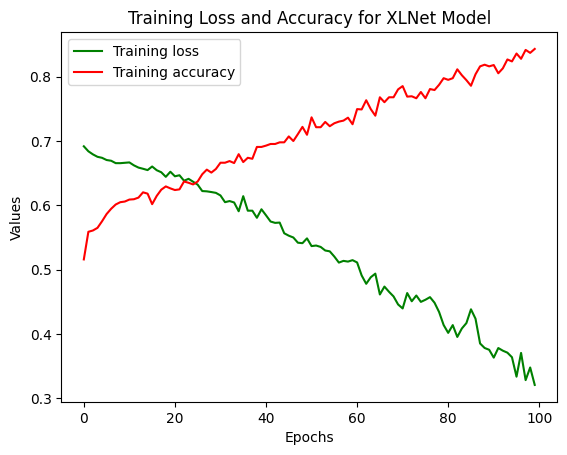

In [ ]:

import matplotlib.pyplot as plt

train_loss = history.history['loss']
train_acc = history.history['accuracy']
epochs = range(0, 100)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.title('Training Loss and Accuracy for XLNet Model')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()
plt.show()


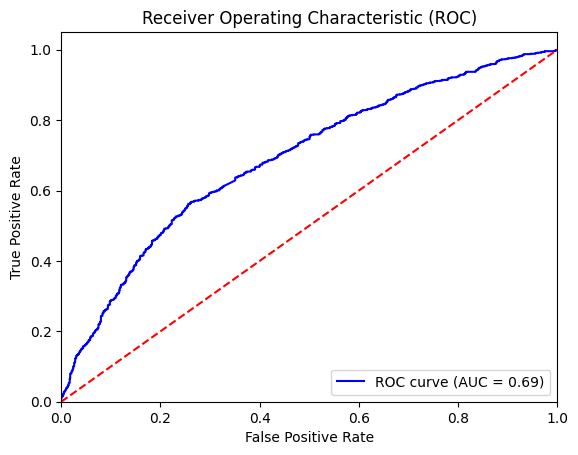

In [ ]:

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()